In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
taxon = 9606
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)
gene_info = ncbi.gene_info(taxon, mode='unambiguous_ensembl')

C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:

In [3]:
ref_literature = datasets.reference_publications(taxon)

In [4]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [5]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 141 ms
Wall time: 124 ms


# BioGRID ORCS

In [6]:
orcs_results = biogrid.orcs('results')
orcs_studies = biogrid.orcs('studies')

In [7]:
orcs_studies['source_id'].value_counts()

29083409    340
30971826    325
29526696     45
27260156     33
28162770     19
           ... 
32728216      1
30898113      1
32005668      1
31353312      1
28768188      1
Name: source_id, Length: 114, dtype: int64

In [8]:
# studies with PMID
orcs_studies = orcs_studies[(orcs_studies['source_type'] == 'pubmed')]
print(len(orcs_studies['source_id'].value_counts()))
# studies in human
orcs_studies = orcs_studies[(orcs_studies['taxon_ncbi'] == 9606)]
print(len(orcs_studies['source_id'].value_counts()))

113
99


In [9]:
orcs_studies = orcs_studies[(orcs_studies['source_type'] == 'pubmed') & 
                            (orcs_studies['taxon_ncbi'] == 9606)]
orcs_studies['source_id'] = orcs_studies['source_id'].astype(int)
orcs_studies['pubmed_id'] = orcs_studies['source_id']
orcs_studies = orcs_studies[orcs_studies['pubmed_id'].isin(gene2pubmed['pubmed_id'])]

In [10]:
# studies with genes in title/abstract
len(orcs_studies['source_id'].value_counts())

21

In [11]:
orcs_results = pd.merge(orcs_results, orcs_studies[['orcs_screen_id', 'pubmed_id']])
orcs_results = orcs_results[orcs_results['hit'] == True].copy()
orcs_results = orcs_results.drop_duplicates(['gene_ncbi', 'pubmed_id'])

In [12]:
len(orcs_results['pubmed_id'].value_counts())

21

In [13]:
#orcs_results['pubmed_id'].drop_duplicates().to_csv('../data/crispr_pubmed_ids.csv', index=False)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-20.0, 60.0)

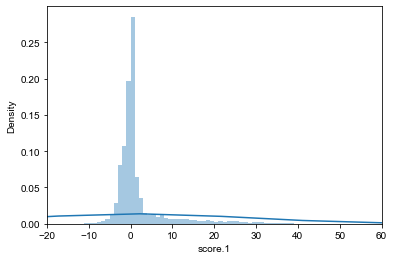

In [14]:
bins = np.arange(-20,40,1)
sns.distplot(orcs_results['score.1'], bins=bins)
plt.xlim([-20,60])

In [15]:
%%time
icite = nih.icite(dataset='citations')

CPU times: total: 21.7 s
Wall time: 24.5 s


In [25]:
def get_genes(gwas):
    
    prot_genes = set(gene_info[gene_info['type_of_gene'] == 'protein-coding']['gene_ncbi'])
    
    # apply filters and p-value threshold here
    gwas = gwas[(gwas['pubmed_id'].isin(gene2pubmed['pubmed_id']))].copy()
    
    print(str(len(set(gwas['pubmed_id'].values))) + ' CRISPR articles')
    
    icite_slice = icite[icite['referenced'].isin(gwas['pubmed_id'])].copy()
    icite_slice = pd.merge(icite_slice, gene2pubmed, left_on='citing', right_on='pubmed_id')
    print(icite_slice['citing'].nunique())

    de_dict = gwas.groupby('pubmed_id')['gene_ncbi'].apply(set).to_dict()
    de_dict_mentioned_genes = (
        gene2pubmed[gene2pubmed['pubmed_id']
                    .isin(gwas['pubmed_id'])]
        .groupby('pubmed_id')['gene_ncbi']
        .apply(set).to_dict()
    )
    de_dict_citations_mentioned_genes = icite_slice.groupby('referenced')['gene_ncbi'].apply(set).to_dict()

    np.random.seed(49)
    n_samp = 100
    de_sets = []
    de_mentioned_sets = []
    de_mentioned_sets_null = []
    de_citations_mentioned_sets = []
    citations_mentioned_sets = []
    result_df_array = []
    for comparison_key in np.unique(gwas['pubmed_id'].values):
        
        ### Collect all sets of unique genes
        de_list = de_dict.get(comparison_key) & prot_genes

        if de_dict_mentioned_genes.get(comparison_key):
            de_list_mentioned_genes = de_dict_mentioned_genes.get(comparison_key) & de_list
        else:
            de_list_mentioned_genes = set()
            
        if de_dict_citations_mentioned_genes.get(comparison_key):
            de_list_citations_mentioned_genes = de_dict_citations_mentioned_genes.get(comparison_key) & de_list
        else:
            de_list_citations_mentioned_genes = set()

        for n_n in range(n_samp):
            de_mentioned_sets_null.append(set(np.random.choice(list(de_list), 
                                                               replace=False, size=len(de_list_mentioned_genes))))

        de_sets.append(de_list)
        de_mentioned_sets.append(de_list_mentioned_genes)
        de_citations_mentioned_sets.append(de_list_citations_mentioned_genes)
        
        ### Impute transition probabilities
        result_df = pd.DataFrame()
        result_df['gene_ncbi'] = list(de_list)
        result_df['comparison'] = comparison_key
        result_df['mentioned'] = result_df['gene_ncbi'].isin(de_list_mentioned_genes)
        result_df['mentioned_citations'] = result_df['gene_ncbi'].isin(de_list_citations_mentioned_genes)
        result_df_array.append(result_df)
        
    ### Collect unique genes
    de_list = set().union(*de_sets)
    de_list_mentioned = set().union(*de_mentioned_sets)
    de_list_mentioned_genes_null = set().union(*de_mentioned_sets_null)
    de_list_citations_mentioned = set().union(*de_citations_mentioned_sets)
    
    ### Collect data for each set
    result_df = pd.concat(result_df_array)
    
    helper = result_df.groupby('comparison').sum()#['mentioned']
    prohib_ids = helper[helper['mentioned'] == 0].index.values
    result_df = result_df[~result_df['comparison'].isin(prohib_ids)]
    result_df['hit'] = True
    result_df = result_df.rename(columns={'comparison':'pubmed_id'})
    print(str(len(set(result_df['pubmed_id'].values))) + ' valid CRISPR articles')
    
    result_df.to_csv('../data/crispr_all_hits.csv', index=False)
    return result_df

In [26]:
result_df, icite_slice = get_genes(orcs_results)

21 CRISPR articles
36
15 valid CRISPR articles


ValueError: too many values to unpack (expected 2)

In [24]:
print(result_df[result_df['hit']]['gene_ncbi'].nunique())

print(result_df[result_df['mentioned']]['gene_ncbi'].nunique())

print(result_df[result_df['mentioned_citations']]['gene_ncbi'].nunique())

9268
18
19
